Best Parameters Found: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

Test Set Evaluation Metrics:
Accuracy:  0.7926
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   0.6731


/Users/paulotto/Developer/hertieAssignments/mlPaper/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


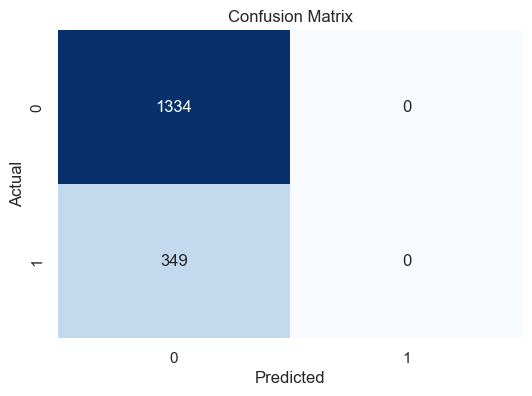

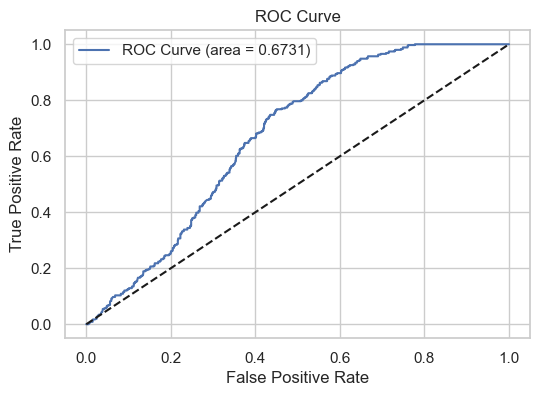

In [7]:
#!/usr/bin/env python
"""
This script predicts democratic backsliding events using logistic regression.
It uses Polars to load and preprocess the V-Dem dataset and scikit-learn
for modeling and evaluation.
"""

import polars as pl
import pandas as pd
import numpy as np
from functools import reduce
import operator

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style to mimic ggplot2
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

# -------------------------------
# 1. Data Loading & Preprocessing
# -------------------------------

# Load the V-Dem dataset from a Parquet file
# Adjust the file path to your dataset
df = pl.read_parquet("../vdemData/V-Dem-CY-Full+Others-v15.parquet")

# Sort the data by country and year (to maintain time order)
df = df.sort(["country_name", "year"])

# Construct the target variable:
# For each country, calculate the future value of the Liberal Democracy Index (v2x_libdem)
# by shifting the column by 3 rows (corresponding to 3 years ahead)
df = df.with_columns(pl.col("v2x_libdem").shift(-3).alias("v2x_libdem_future"))

# Compute the change over 3 years (future value minus current value)
df = df.with_columns((pl.col("v2x_libdem_future") - pl.col("v2x_libdem")).alias("drop"))

# Define backslide: assign 1 if the change is ≤ -0.1, else 0.
df = df.with_columns((pl.col("drop") <= -0.1).cast(pl.Int32).alias("backslide"))

# Remove observations with missing target values (e.g. last 3 years per country)
df = df.drop_nulls(subset=["backslide"])

# -------------------------------
# 2. Select Features & Handle Missing Data
# -------------------------------

# Define the predictors/features
features = [
    "v2juhcind",  # Judicial independence
    "v2mecenefm",  # Media freedom
    "v2xcs_ccsi",  # Civil society robustness
    "v2xeg_eqdr",  # Economic equality measures
]

# Combine null-check conditions for all selected features
null_condition = reduce(operator.and_, [pl.col(col).is_not_null() for col in features])
df = df.filter(null_condition)

# -------------------------------
# 3. Train-Test Split
# -------------------------------
# We use a time-aware split: earlier years for training, later years for testing.
# Here, we use year < 2015 for training and >= 2015 for testing.
train_df = df.filter(pl.col("year") < 2015)
test_df = df.filter(pl.col("year") >= 2015)

# Convert to Pandas DataFrames for scikit-learn processing
train_pdf = train_df.select(features + ["backslide"]).to_pandas()
test_pdf = test_df.select(features + ["backslide"]).to_pandas()

X_train = train_pdf[features]
y_train = train_pdf["backslide"]

X_test = test_pdf[features]
y_test = test_pdf["backslide"]

# -------------------------------
# 4. Feature Scaling
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 5. Logistic Regression Modeling
# -------------------------------
# Initialize Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Hyperparameter grid for regularization strength and penalty type.
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"],  # 'liblinear' supports l1 and l2 penalties.
}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_logreg = grid_search.best_estimator_
print("Best Parameters Found:", grid_search.best_params_)

# -------------------------------
# 6. Model Evaluation
# -------------------------------
# Predict on the test set
y_pred = best_logreg.predict(X_test_scaled)
y_pred_proba = best_logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nTest Set Evaluation Metrics:")
print("Accuracy:  {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F1 Score:  {:.4f}".format(f1))
print("ROC AUC:   {:.4f}".format(roc_auc))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label="ROC Curve (area = {:.4f})".format(roc_auc))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

In [10]:
import polars as pl

# Load the V-Dem dataset (adjust the file path as necessary)
df = pl.read_parquet("../vdemData/V-Dem-CY-Full+Others-v15.parquet")

# Create the 'backslide' column
df = df.with_columns(pl.col("v2x_libdem").shift(-3).alias("v2x_libdem_future"))
df = df.with_columns((pl.col("v2x_libdem_future") - pl.col("v2x_libdem")).alias("drop"))
df = df.with_columns((pl.col("drop") <= -0.1).cast(pl.Int32).alias("backslide"))
df = df.drop_nulls(subset=["backslide"])

# Option 1: Filter rows where backslide == 1 and count the number of rows.
num_backslides = df.filter(pl.col("backslide") == 1).height
print("Number of democratic backslide events:", num_backslides)

# Option 2: Sum the backslide column (since it's binary, the sum equals the count of backslides)
sum_backslides = df.select(pl.col("backslide").sum()).to_numpy()[0][0]
print("Total backslides counted (using sum):", sum_backslides)

Number of democratic backslide events: 701
Total backslides counted (using sum): 701


In [12]:
import polars as pl

# Load the V-Dem dataset (adjust the file path as necessary)
df = pl.read_parquet("../vdemData/V-Dem-CY-Full+Others-v15.parquet")

# Create the 'backslide' column based on the 3-year difference
df = df.with_columns(pl.col("v2x_libdem").shift(-3).alias("v2x_libdem_future"))
df = df.with_columns((pl.col("v2x_libdem_future") - pl.col("v2x_libdem")).alias("drop"))
df = df.with_columns((pl.col("drop") <= -0.1).cast(pl.Int32).alias("backslide"))
df = df.drop_nulls(subset=["backslide"])

# Filter rows where a backslide event occurred (backslide equals 1)
df_backslides = df.filter(pl.col("backslide") == 1)

# Extract a list of unique countries that have experienced a backslide event
countries_with_backslide = df_backslides.select("country_name").unique()

print("Countries with at least one democratic backslide event:")
print(countries_with_backslide)

Countries with at least one democratic backslide event:
shape: (146, 1)
┌──────────────────────────┐
│ country_name             │
│ ---                      │
│ str                      │
╞══════════════════════════╡
│ United States of America │
│ Jamaica                  │
│ Armenia                  │
│ Cuba                     │
│ Germany                  │
│ …                        │
│ Peru                     │
│ Solomon Islands          │
│ Benin                    │
│ Botswana                 │
│ Nepal                    │
└──────────────────────────┘


In [16]:
import polars as pl

# Load the V-Dem dataset (adjust the file path as necessary)
df = pl.read_parquet("../vdemData/V-Dem-CY-Full+Others-v15.parquet")

# Create the 'backslide' column based on the 3-year difference
df = df.with_columns(pl.col("v2x_libdem").shift(-3).alias("v2x_libdem_future"))
df = df.with_columns((pl.col("v2x_libdem_future") - pl.col("v2x_libdem")).alias("drop"))
df = df.with_columns((pl.col("drop") <= -0.1).cast(pl.Int32).alias("backslide"))
df = df.drop_nulls(subset=["backslide"])

# Filter rows where a backslide event occurred (backslide equals 1)
df_backslides = df.filter(pl.col("backslide") == 1)

# Group by country and count the number of backslide events each experienced,
# then filter to show only countries with at least one backslide.
country_backslide_df = (
    df.group_by("country_name")
    .agg(pl.col("backslide").sum().alias("num_backslides"))
    .filter(pl.col("num_backslides") > 0)
)

# Sort the DataFrame ascending by the number of backslides
country_backslide_df = country_backslide_df.sort("num_backslides", descending=True)

print(
    "DataFrame of Countries with Backslide Events and their Counts (sorted ascending):"
)
print(country_backslide_df)

DataFrame of Countries with Backslide Events and their Counts (sorted ascending):
shape: (146, 2)
┌─────────────────────────────────┬────────────────┐
│ country_name                    ┆ num_backslides │
│ ---                             ┆ ---            │
│ str                             ┆ i32            │
╞═════════════════════════════════╪════════════════╡
│ Uruguay                         ┆ 19             │
│ Argentina                       ┆ 16             │
│ Poland                          ┆ 16             │
│ Peru                            ┆ 15             │
│ Greece                          ┆ 12             │
│ …                               ┆ …              │
│ Azerbaijan                      ┆ 1              │
│ Russia                          ┆ 1              │
│ Mongolia                        ┆ 1              │
│ German Democratic Republic      ┆ 1              │
│ Democratic Republic of the Con… ┆ 1              │
└─────────────────────────────────┴────────────────┘


In [18]:
country_backslide_df.write_csv("../writeup/test.csv")